In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os
sys.path.append('../SelectionFunctionToolkit')

### Check selection function

In [4]:
import matplotlib.pyplot as plt, matplotlib
import numpy as np, healpy as hp, h5py
from scipy import stats, special, linalg, optimize
import scipy
import tqdm

from pylab import cm

# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=24)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)
plt.rc('legend',fontsize=24)
plt.rc('font',size=24)

In [5]:
import warnings
warnings.filterwarnings("ignore", message="You are modifying the state of a globally registered colormap.")
warnings.filterwarnings("ignore", message="Passing parameters norm and vmin/vmax simultaneously is deprecated")
warnings.filterwarnings("ignore", message="divide by zero encountered")
warnings.filterwarnings("ignore", message="overflow encountered in exp")

In [6]:
def add_log_cbar(ax, vmin=0., vmax=1., cmap='viridis',
             orientation='vertical', ticks=[0,1], tick_labels=['0','1']):

    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    im = plt.cm.ScalarMappable(norm=norm, cmap=cmap); im.set_array([])

    tick_pos = (np.log(np.array(ticks)) - np.log(vmin))/(np.log(vmax)-np.log(vmin))
    cbar = plt.colorbar(im, cax=ax, orientation=orientation, ticks=tick_pos)

    if orientation=='vertical':
        cbar.ax.set_yticklabels(tick_labels)
    else:
        cbar.ax.set_xticklabels(tick_labels)
    #print(tick_pos, tick_labels)

    return cbar

def plothist(values, bins, density=False, count=None, **kwargs):
    if count==None:
        count=len(values)
        
    y = np.histogram(values, bins)[0].astype(float)
    if density: y /= ((bins[1:]-bins[:-1]) * count)
    
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(y,2), (0,len(y)*2), (0,0))
    
    plt.plot(x,y,**kwargs)
    
def logit(p):
    return np.log(p/(1-p))
def expit(x):
    return 1/(1+np.exp(-x))

## Load in Data

In [8]:
with h5py.File(f'/data/asfe2/Projects/astrometry/gaiaedr3_rvs_kncounts_Gres10CRres2hpx7.h', 'r') as hf:
        print(hf.keys())
        print(hf['magnitude'][...])

<KeysViewHDF5 ['colour', 'k', 'magnitude', 'n', 'position']>
[ 17  18  19 ... 180 180 180]


In [9]:
box={};

dsets = []

for sample in ['rvs','ruwe1p4','astrometry']:
    box[sample] = {}
    with h5py.File(f'/data/asfe2/Projects/astrometry/gaiaedr3_{sample}_kncounts_hpx9.h', 'r') as hf:
        box[sample]['n'] = hf['n'][...][0,0].astype(np.int64)
        box[sample]['k'] = hf['k'][...][0,0].astype(np.int64)

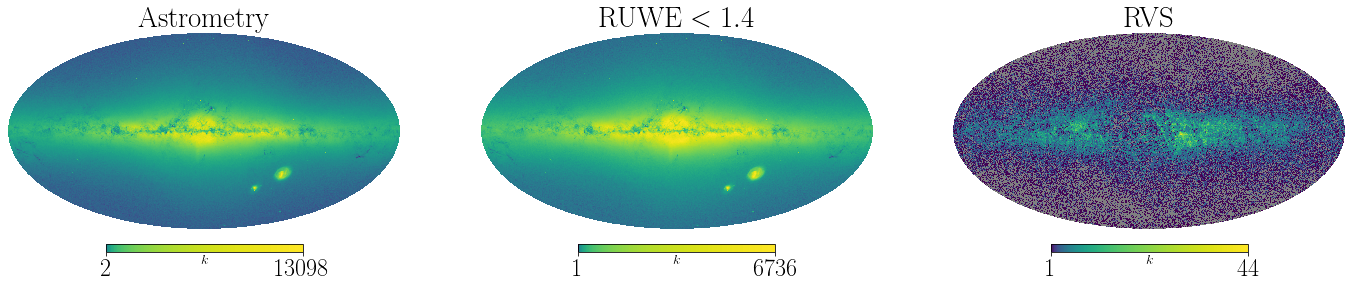

In [10]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))

labels = {'astrometry':'Astrometry', 'ruwe1p4':r'$\mathrm{RUWE}<1.4$','rvs':'RVS'}

minmax = [-4,4]

for i, sample in enumerate(['astrometry','ruwe1p4','rvs']):
    plt.sca(axes[i])
    arr = box[sample]['k'].copy().astype(float)
    arr[arr==0] = np.nan
    hp.mollview(arr, nest=True, notext=True,unit=r'$k$',norm='log',
                coord=['C','G'], title=labels[sample], cmap='viridis', hold=True, cbar=True, xsize=2000)

plt.savefig('figs/sample_k_3hpx.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

In [8]:
_downgrade = lambda A: A.reshape(M, A.shape[0]//M, 
                                 C, A.shape[1]//C, 
                                 hp.nside2npix(nside), A.shape[2]//hp.nside2npix(nside)).sum(axis=(1,3,5))

$$ P( k | n, p ) = \mathrm{Binomial}( k ; n, p) $$

$$ P( p | k, n ) = \frac{\mathrm{Binomial}( k ; n, p) \, \mathrm{Beta}(p | \alpha, \beta)}{\int \mathrm{d}p\, \mathrm{Binomial}( k ; n, p) \,\mathrm{Beta}(p | \alpha, \beta)} \\
= \mathrm{Beta}(p | \alpha+k, \beta+n-k)$$

$$ \mathbb{E}[p] = (\alpha + k)/(\alpha + \beta + n) $$

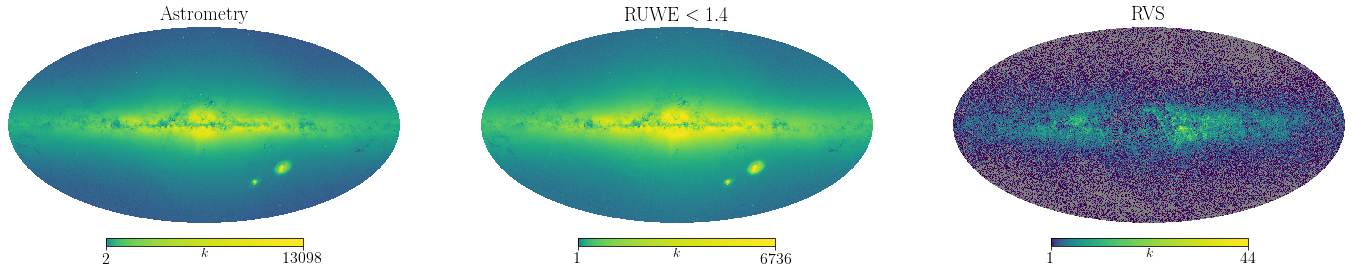

In [40]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))

labels = {'astrometry':'Astrometry', 'ruwe1p4':r'$\mathrm{RUWE}<1.4$','rvs':'RVS'}

minmax = [-4,4]

for i, sample in enumerate(['astrometry','ruwe1p4','rvs']):
    plt.sca(axes[i])
    arr = box[sample]['k'].copy().astype(float)
    arr[arr==0] = np.nan
    hp.mollview(arr, nest=True, notext=True,unit=r'$k$',norm='log',
                coord=['C','G'], title=labels[sample], cmap='viridis', hold=True, cbar=True, xsize=2000)

plt.savefig('figs/sample_k_3hpx.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

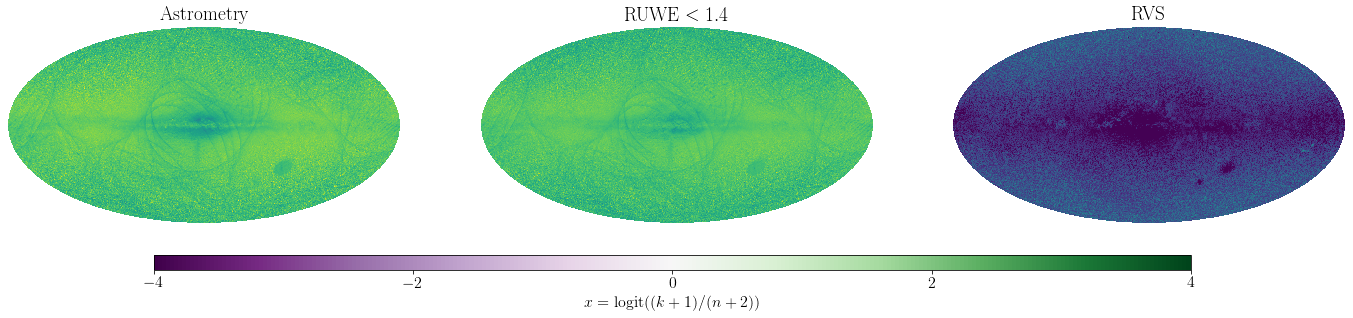

In [32]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))

labels = {'astrometry':'Astrometry', 'ruwe1p4':r'$\mathrm{RUWE}<1.4$','rvs':'RVS'}

minmax = [-4,4]

for i, sample in enumerate(['astrometry','ruwe1p4','rvs']):
    plt.sca(axes[i])
    hp.mollview(logit((box[sample]['k']+1)/(box[sample]['n']+2)), nest=True, notext=True, min=minmax[0],max=minmax[1],
                coord=['C','G'], title=labels[sample], cmap='viridis', hold=True, cbar=False, xsize=2000)

ax = fig.add_axes([0.21, 0.1, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], minmax[0]/2, 0., minmax[1]/2, minmax[1]])
cbar.set_label(r'$x = \mathrm{logit}((k+1)/(n+2))$', fontsize=16)

plt.savefig('figs/expected_x_3hpx.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# Colour-Magnitude counts BP-RP

In [21]:
box = {}
with h5py.File('/data/asfe2/Projects/astrometry/gaiaedr3_all_kncounts_Gres10Cres10.h', 'r') as hf:
    for key in hf.keys():
        box[key]=hf[key][...]

In [22]:
eps=1e-10
mag_res = 0.1; col_res = 0.1;

sample="all"; file="Gres10Cres10"
box={}; dsets = ['n_full', 'n_ast5', 'n_ast6', 'n_ruwe', 'n_rvs']
with h5py.File(f'/data/asfe2/Projects/astrometry/gaiaedr3_{sample}_kncounts_{file}.h', 'r') as hf:
    
    nanmag = hf['magnitude'][...]<-999
    nancol = hf['colour'][...]<-999
    
    
    Mlims = [np.min(hf['magnitude'][...][~nanmag])*mag_res,
             np.max(hf['magnitude'][...][~nanmag]+1)*mag_res]; 
    Clims = [np.min(hf['colour'][...][~nancol])*col_res,
             np.max(hf['colour'][...][~nancol]+1)*col_res]; 
    M_bins = np.arange(Mlims[0], Mlims[1]+1+eps, mag_res)
    C_bins = np.arange(Clims[0], Clims[1]+1+eps, col_res)

    Midx = hf['magnitude'][...] - int(Mlims[0]/mag_res + eps)
    Midx[nanmag] = M_bins.shape[0]-2
    Cidx = hf['colour'][...] - int(Clims[0]/col_res + eps)
    Cidx[nancol] = C_bins.shape[0]-2
    
    
    for key in dsets:
        box[key] = np.zeros((M_bins.shape[0]-1, C_bins.shape[0]-1), dtype=np.int64)
        box[key][Midx, Cidx] = hf[key][...]    

In [23]:
box['n_ast'] = box['n_ast5']+box['n_ast6']
dsets = ['n_full', 'n_ast', 'n_ruwe', 'n_rvs']

In [27]:
plt.rc('axes', labelsize=24)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)
plt.rc('legend',fontsize=24)

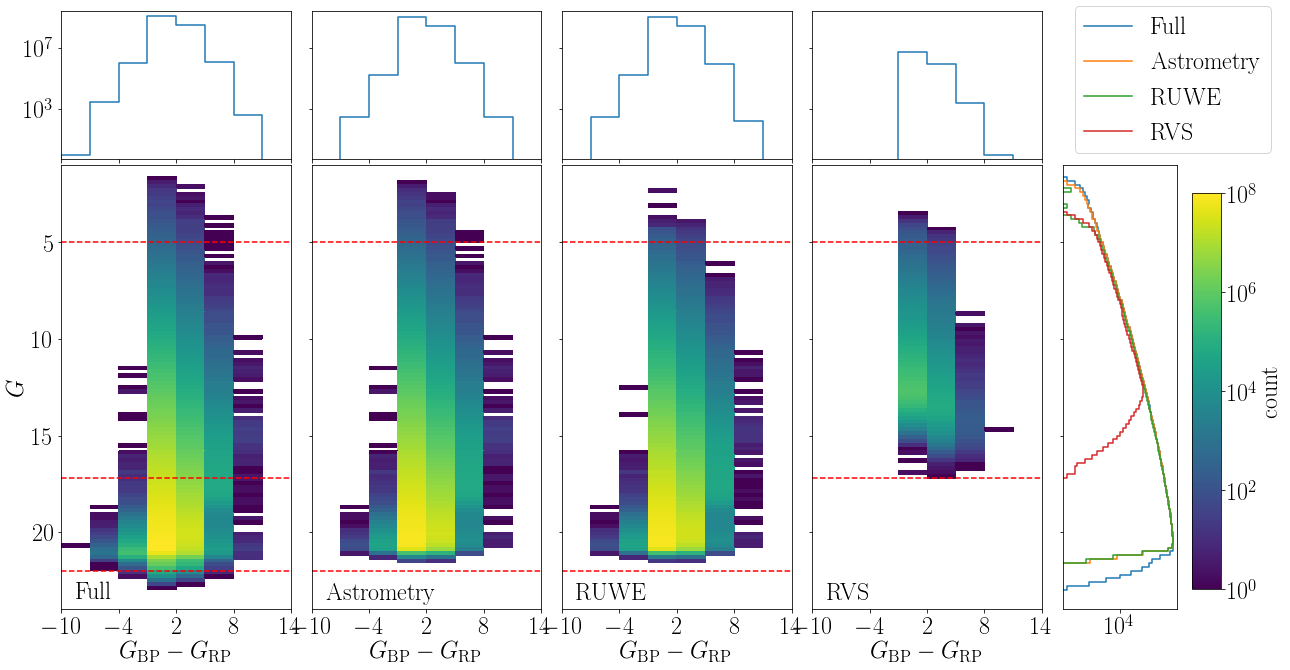

In [247]:
Mlim = [1,24]; mag_wth=0.2
M = int((Mlim[1]-Mlim[0]+eps)/mag_wth)
Clim = [-10,14]; col_wth=3.
C = int((Clim[1]-Clim[0]+eps)/col_wth)

labels = {'n_full':'Full', 'n_ast':'Astrometry', 'n_ruwe':'RUWE', 'n_rvs':'RVS'}
g_ranges = {'n_full':[5.,22.], 'n_ast':[5.,22.], 'n_ruwe':[5.,22.], 'n_rvs':[5.,17.2]}

fig,axes = plt.subplots(2,len(dsets)+1,figsize=(20,11), sharex='col', sharey='row', 
                        gridspec_kw={'height_ratios':[1,3], 'width_ratios':[2,]*len(dsets)+[1,]})
for i, key in enumerate(dsets):
    plt.sca(axes[1,i])
    
    n = box[key][:-1,:-1].copy()
    n = np.vstack((np.zeros((int((M_bins[0]-Mlim[0])/mag_res + eps), n.shape[1])), n))
    n = np.vstack((n, np.zeros((int((Mlim[1]-M_bins[-2])/mag_res + eps), n.shape[1]))))
    n = np.hstack((np.zeros((int((C_bins[0]-Clim[0])/col_res + eps), n.shape[0])).T, n))
    n = np.hstack((n, np.zeros((int((Clim[1]-C_bins[-2])/col_res + eps), n.shape[0])).T))
    n = np.sum(_downgrade(n,M,C), axis=(1,3))
    if i==0: 
        nmax = np.max(n)
        mag_nmax = np.max(np.sum(n, axis=1))
        col_nmax = np.max(np.sum(n, axis=0))
    
    plt.pcolor(np.arange(Clim[0], Clim[1]+eps, col_wth), 
               np.arange(Mlim[0], Mlim[1]+eps, mag_wth), 
               n, norm=LogNorm(), cmap='viridis', vmin=1., vmax=nmax)
    plt.text(-8.5,23.5,labels[key], fontsize=24)
    plt.xlabel(r'$G_\mathrm{BP} - G_\mathrm{RP}$')
    
    plt.xticks(np.arange(Clim[0], Clim[1]+eps, col_wth)[::2])
    
    plt.plot(Clim, [g_ranges[key][0], g_ranges[key][0]], '--r')
    plt.plot(Clim, [g_ranges[key][1], g_ranges[key][1]], '--r')
    if i==0: plt.plot(Clim, [g_ranges['n_rvs'][1], g_ranges['n_rvs'][1]], '--r')
    
    plt.sca(axes[0,i])
    chist = np.sum(n, axis=0)
    y = np.insert(np.repeat(chist,2), (0,len(chist)*2), (0,0))
    x = np.repeat(np.arange(Clim[0], Clim[1]+eps, col_wth),2)
    plt.plot(x,y)
    plt.yscale('log')
    plt.ylim(.5,col_nmax*2)
    
    plt.sca(axes[1,len(dsets)])
    mhist = np.sum(n, axis=1)
    y = np.insert(np.repeat(mhist,2), (0,len(mhist)*2), (0,0))
    x = np.repeat(np.arange(Mlim[0], Mlim[1]+eps, mag_wth),2)
    plt.plot(y,x,label=labels[key])
    plt.xscale('log')
    plt.xlim(0.5,mag_nmax*2)
plt.legend(bbox_to_anchor=[0.,1.])
    
plt.sca(axes[1,0]); plt.ylabel(r'$G$'); plt.ylim(Mlim[1],Mlim[0])
plt.sca(axes[0,len(dsets)]); plt.axis('off')
    
plt.subplots_adjust(hspace=0.02, wspace=0.1)


ax = fig.add_axes([0.91, 0.15, 0.02, 0.5]); 
ticks = np.logspace(0,8,5)
cbar = add_log_cbar(ax, vmin=1., vmax=1e8, cmap='viridis', orientation='vertical',
                   ticks = ticks, tick_labels=[f'$10^{{{i:.0f}}}$' for i in np.log10(ticks)])
cbar.set_label(r'count', fontsize=24)


plt.savefig('figs/cm_counts_CBR.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# Colour-Magnitude counts: G - RP

In [17]:
_downgrade = lambda A, M, C: A.reshape(M, A.shape[0]//M, C, A.shape[1]//C)

In [18]:
eps=1e-10
mag_res = 0.1; col_res = 0.1;

sample="all"; file="Gres10CRres10"
box={}; dsets = ['n_full', 'n_ast5', 'n_ast6', 'n_ruwe', 'n_rvs']
with h5py.File(f'/data/asfe2/Projects/astrometry/gaiaedr3_{sample}_kncounts_{file}.h', 'r') as hf:
    
    nanmag = hf['magnitude'][...]<-999
    nancol = hf['colour'][...]<-999
    
    
    Mlims = [np.min(hf['magnitude'][...][~nanmag])*mag_res,
             np.max(hf['magnitude'][...][~nanmag]+1)*mag_res]; 
    Clims = [np.min(hf['colour'][...][~nancol])*col_res,
             np.max(hf['colour'][...][~nancol]+1)*col_res]; 
    M_bins = np.arange(Mlims[0], Mlims[1]+1+eps, mag_res)
    C_bins = np.arange(Clims[0], Clims[1]+1+eps, col_res)

    Midx = hf['magnitude'][...] - int(Mlims[0]/mag_res + eps)
    Midx[nanmag] = M_bins.shape[0]-2
    Cidx = hf['colour'][...] - int(Clims[0]/col_res + eps)
    Cidx[nancol] = C_bins.shape[0]-2
    
    
    for key in dsets:
        box[key] = np.zeros((M_bins.shape[0]-1, C_bins.shape[0]-1), dtype=np.int64)
        box[key][Midx, Cidx] = hf[key][...]    

In [19]:
box['n_ast'] = box['n_ast5']+box['n_ast6']
dsets = ['n_full', 'n_ast', 'n_ruwe', 'n_rvs']

In [20]:
Mlims_idx = np.sum(M_bins<5)-1, np.sum(M_bins<22)
ruwe_contingency = np.array([[np.sum(box['n_full'][Mlims_idx[0]:Mlims_idx[1]]), 
                             np.sum(box['n_ruwe'][Mlims_idx[0]:Mlims_idx[1]])],
                            [np.sum(box['n_full'][Mlims_idx[0]:Mlims_idx[1],:-1]),
                             np.sum(box['n_ruwe'][Mlims_idx[0]:Mlims_idx[1],:-1])]])
print(f"n total (5<G<22): {ruwe_contingency[0,0]}")
print(f"n ruwe (5<G<22): {ruwe_contingency[0,1]}")
print(f"n colour (5<G<22): {ruwe_contingency[1,0]}")
print(f"n both (5<G<22): {ruwe_contingency[1,1]}")
print("")
Mlims_idx = np.sum(M_bins<5)-1, np.sum(M_bins<17.2)
rvs_contingency = np.array([[np.sum(box['n_full'][Mlims_idx[0]:Mlims_idx[1]]), 
                             np.sum(box['n_rvs'][Mlims_idx[0]:Mlims_idx[1]])],
                            [np.sum(box['n_full'][Mlims_idx[0]:Mlims_idx[1],:-1]),
                             np.sum(box['n_rvs'][Mlims_idx[0]:Mlims_idx[1],:-1])]])
print(f"n total (5<G<17.2): {rvs_contingency[0,0]}")
print(f"n rvs (5<G<17.2): {rvs_contingency[0,1]}")
print(f"n colour (5<G<17.2): {rvs_contingency[1,0]}")
print(f"n both (5<G<17.2): {rvs_contingency[1,1]}")

n total (5<G<22): 1806158223
n ruwe (5<G<22): 1400802478
n colour (5<G<22): 1551060494
n both (5<G<22): 1292199443

n total (5<G<17.2): 174495806
n rvs (5<G<17.2): 6188719
n colour (5<G<17.2): 172577819
n both (5<G<17.2): 6186382


In [21]:
print('RUWE contingency')
contingency = ruwe_contingency.copy()
print(contingency[0,1]/contingency[0,0])
print(contingency[1,1]/contingency[1,0])
print()
print(contingency[1,0]/contingency[0,0])
print(contingency[1,1]/contingency[0,1])


print('RVS contingency')
contingency = rvs_contingency.copy()
print(contingency[0,1]/contingency[0,0])
print(contingency[1,1]/contingency[1,0])
print()
print(contingency[1,0]/contingency[0,0])
print(contingency[1,1]/contingency[0,1])

RUWE contingency
0.7755701910064609
0.8331070567515854

0.8587622469883692
0.9224708431733657
RVS contingency
0.03546629080586613
0.03584691263249769

0.989008406310923
0.9996223774257645


In [22]:
counts = {}
counts['full'] = np.sum(box['n_full'][:-1], axis=1)
counts['fullRP'] = np.sum(box['n_full'][:-1,:-1], axis=1)
counts['ruwe'] = np.sum(box['n_ruwe'][:-1], axis=1)
counts['ruweRP'] = np.sum(box['n_ruwe'][:-1,:-1], axis=1)
counts['rvs'] = np.sum(box['n_rvs'][:-1], axis=1)
counts['rvsRP'] = np.sum(box['n_rvs'][:-1,:-1], axis=1)

(0.0, 1.0)

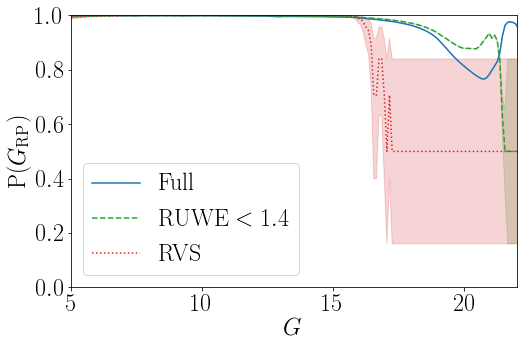

In [23]:
plt.figure(figsize=(8,5))

cdefault = plt.rcParams['axes.prop_cycle'].by_key()['color']

percentiles = np.repeat(np.array([0.16,0.5,0.84])[None,:],len(counts['fullRP']), axis=0).T

p = scipy.stats.beta.ppf(percentiles, a=(counts['fullRP']+1), b=(counts['full']-counts['fullRP']+1))
plt.plot((M_bins[1:-1]+M_bins[:-2])/2, p[1], c=cdefault[0], label='Full')
plt.fill_between((M_bins[1:-1]+M_bins[:-2])/2, p[0],p[2], color=cdefault[0], alpha=0.2)

p = scipy.stats.beta.ppf(percentiles, a=(counts['ruweRP']+1), b=(counts['ruwe']-counts['ruweRP']+1))
plt.plot((M_bins[1:-1]+M_bins[:-2])/2, p[1], c=cdefault[2], linestyle='--', label=r'$\mathrm{RUWE}<1.4$')
plt.fill_between((M_bins[1:-1]+M_bins[:-2])/2, p[0],p[2], color=cdefault[2], alpha=0.2)

p = scipy.stats.beta.ppf(percentiles, a=(counts['rvsRP']+1), b=(counts['rvs']-counts['rvsRP']+1))
plt.plot((M_bins[1:-1]+M_bins[:-2])/2, p[1], c=cdefault[3], linestyle=':', label=r'RVS')
plt.fill_between((M_bins[1:-1]+M_bins[:-2])/2, p[0],p[2], color=cdefault[3], alpha=0.2)

plt.xlabel(r'$G$')
plt.ylabel(r'$\mathrm{P}(G_\mathrm{RP})$')
plt.legend(loc='lower left')

plt.xlim(5,22)
plt.ylim(0,1)

# plt.savefig('figs/prob_Grp.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

### Messing around with Fisher exact tests

In [234]:
contingency = np.array([[5,3],
                        [5,1]])
scipy.stats.fisher_exact(contingency, alternative='less')

(0.3333333333333333, 0.4055944055944053)

In [235]:
lnp = 0.
for i in range(2):
    lnp += np.sum(np.log(np.arange(1,contingency[i,0]+contingency[i,1]+eps)))
    lnp += np.sum(np.log(np.arange(1,contingency[0,i]+contingency[1,i]+eps)))
    for j in range(2):
        lnp -= np.sum(np.log(np.arange(1,contingency[i,j]+eps)))
lnp -= np.sum(np.log(np.arange(1,np.sum(contingency)+eps)))
lnp, np.exp(lnp)

(-1.0916436193520198, 0.3356643356643345)

In [236]:
p = 1.
for i in range(2):
    p *= np.prod(np.arange(1,contingency[i,0]+contingency[i,1]+eps))
    p *= np.prod(np.arange(1,contingency[0,i]+contingency[1,i]+eps))
    for j in range(2):
        p /= np.prod(np.arange(1,contingency[i,j]+eps))
p /= np.prod(np.arange(1,np.sum(contingency)+eps))
p

0.3356643356643357

In [29]:
plt.rc('axes', labelsize=24)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)
plt.rc('legend',fontsize=24)

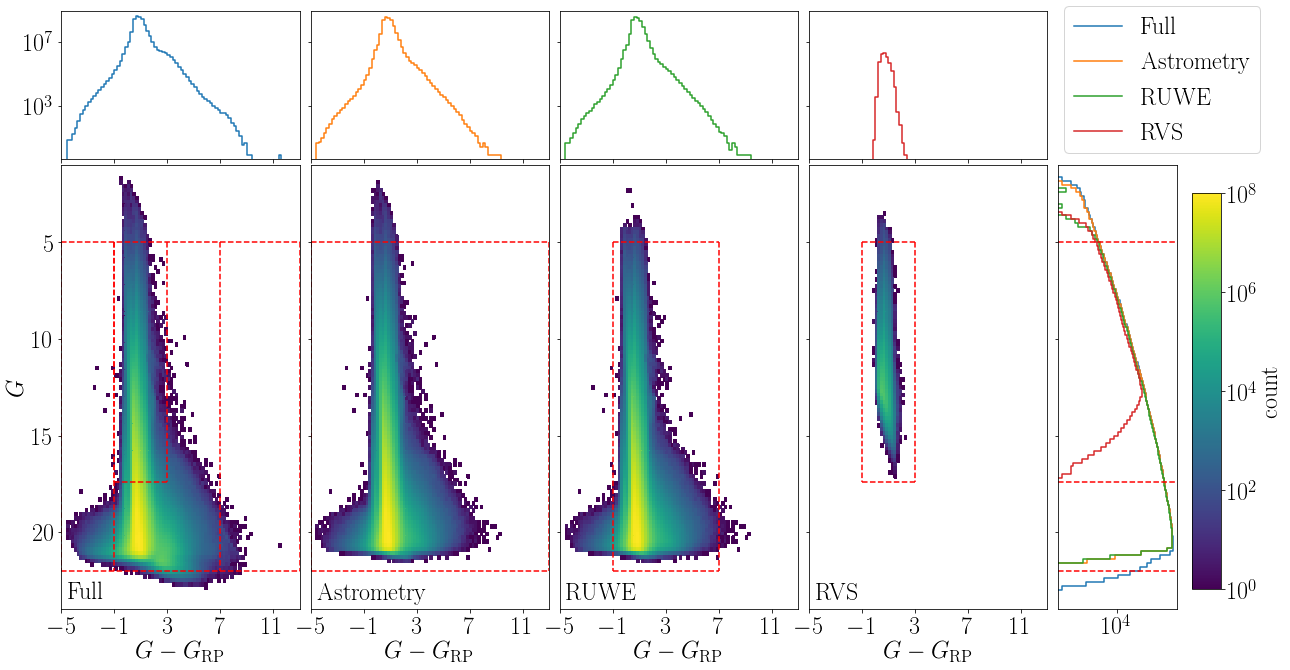

In [24]:
Mlim = [1,24]; mag_wth=0.2
Clim = [-5,13]; col_wth=0.2
# Clim = [-8,13]; col_wth=1.

cdefault = plt.rcParams['axes.prop_cycle'].by_key()['color']
labels = {'n_full':'Full', 'n_ast':'Astrometry', 'n_ruwe':'RUWE', 'n_rvs':'RVS'}
g_ranges = {'n_full':[5.,22.], 'n_ast':[5.,22.], 'n_ruwe':[5.,22.], 'n_rvs':[5.,17.4]}
c_ranges = {'n_full':[-5,13], 'n_ast':[-5,13], 'n_ruwe':[-1,7], 'n_rvs':[-1,3.0]}
col_wths = {'n_full':1., 'n_ast':1., 'n_ruwe':1., 'n_rvs':1.}
col_wths = {'n_full':col_wth, 'n_ast':col_wth, 'n_ruwe':col_wth, 'n_rvs':col_wth}

fig,axes = plt.subplots(2,len(dsets)+1,figsize=(20,11), sharex='col', sharey='row', 
                        gridspec_kw={'height_ratios':[1,3], 'width_ratios':[2,]*len(dsets)+[1,]})
for i, key in enumerate(dsets):
    plt.sca(axes[1,i])
    
    M = int((Mlim[1]-Mlim[0]+eps)/mag_wth)
    C = int((Clim[1]-Clim[0]+eps)/col_wths[key])
    #C = int((Clim[1]-Clim[0]+eps)/2.)
    
    n = box[key][:-1,:-1].copy()
    n = np.vstack((np.zeros((int((M_bins[0]-Mlim[0])/mag_res + eps), n.shape[1])), n))
    n = np.vstack((n, np.zeros((int((Mlim[1]-M_bins[-2])/mag_res + eps), n.shape[1]))))
    n = np.hstack((np.zeros((int((C_bins[0]-Clim[0])/col_res + eps), n.shape[0])).T, n))
    n = np.hstack((n, np.zeros((int((Clim[1]-C_bins[-2])/col_res + eps), n.shape[0])).T))
    n = np.sum(_downgrade(n,M,C), axis=(1,3))
    if i==0: 
        nmax = np.max(n)
        mag_nmax = np.max(np.sum(n, axis=1))
        col_nmax = np.max(np.sum(n, axis=0))
    
    plt.pcolor(np.arange(Clim[0], Clim[1]+eps, col_wths[key]), 
               np.arange(Mlim[0], Mlim[1]+eps, mag_wth), 
               n, norm=LogNorm(), cmap='viridis', vmin=1., vmax=nmax)
    plt.text(-4.5,23.5,labels[key], fontsize=24)
    plt.xlabel(r'$G - G_\mathrm{RP}$')
    
    #plt.xticks(np.arange(Clim[0], Clim[1]+eps, col_wths[key])[::4])
    plt.xticks(np.arange(Clim[0], Clim[1]+eps, 1.)[::4])
    
    plt.plot([c_ranges[key][0], c_ranges[key][1]], [g_ranges[key][0], g_ranges[key][0]], '--r')
    plt.plot([c_ranges[key][0], c_ranges[key][1]], [g_ranges[key][1], g_ranges[key][1]], '--r')
    plt.plot([c_ranges[key][0], c_ranges[key][0]], [g_ranges[key][0], g_ranges[key][1]], '--r')
    plt.plot([c_ranges[key][1], c_ranges[key][1]], [g_ranges[key][0], g_ranges[key][1]], '--r')
    if i==0: 
        plt.plot([c_ranges['n_rvs'][0], c_ranges['n_rvs'][1]], [g_ranges['n_rvs'][1], g_ranges['n_rvs'][1]], '--r')
        plt.plot([c_ranges['n_rvs'][0], c_ranges['n_rvs'][0]], [g_ranges['n_rvs'][0], g_ranges['n_rvs'][1]], '--r')
        plt.plot([c_ranges['n_rvs'][1], c_ranges['n_rvs'][1]], [g_ranges['n_rvs'][0], g_ranges['n_rvs'][1]], '--r')
        plt.plot([c_ranges['n_ruwe'][0], c_ranges['n_ruwe'][0]], [g_ranges['n_ruwe'][0], g_ranges['n_ruwe'][1]], '--r')
        plt.plot([c_ranges['n_ruwe'][1], c_ranges['n_ruwe'][1]], [g_ranges['n_ruwe'][0], g_ranges['n_ruwe'][1]], '--r')
    
    plt.sca(axes[0,i])
    chist = np.sum(n, axis=0)
    y = np.insert(np.repeat(chist,2), (0,len(chist)*2), (0,0))
    x = np.repeat(np.arange(Clim[0], Clim[1]+eps, col_wths[key]),2)
    plt.plot(x,y,c=cdefault[i])
    plt.yscale('log')
    plt.ylim(.5,col_nmax*2)
    
    if (i==0) & False:
        print(int((g_ranges['n_ruwe'][0]-Mlim[0])/mag_wth + eps),-int((Mlim[1]-g_ranges['n_ruwe'][1])/mag_wth + eps))
        chist = np.sum(n[int((g_ranges['n_ruwe'][0]-Mlim[0])/mag_wth + eps):\
                        -int((Mlim[1]-g_ranges['n_ruwe'][1])/mag_wth + eps)], axis=0)
        y = np.insert(np.repeat(chist,2), (0,len(chist)*2), (0,0))
        x = np.repeat(np.arange(Clim[0], Clim[1]+eps, col_wths[key]),2)
        plt.plot(x,y,c=cdefault[2],linestyle='--')
        plt.yscale('log')
        plt.ylim(.5,col_nmax*2)    
        
        print(int((g_ranges['n_rvs'][0]-Mlim[0])/mag_wth + eps),
                        -int((Mlim[1]-g_ranges['n_rvs'][1])/mag_wth + eps))
        
        chist = np.sum(n[int((g_ranges['n_rvs'][0]-Mlim[0])/mag_wth + eps):\
                        -int((Mlim[1]-g_ranges['n_rvs'][1])/mag_wth + eps)], axis=0)
        y = np.insert(np.repeat(chist,2), (0,len(chist)*2), (0,0))
        x = np.repeat(np.arange(Clim[0], Clim[1]+eps, col_wths[key]),2)
        plt.plot(x,y,c=cdefault[3],linestyle=':')
        plt.yscale('log')
        plt.ylim(.5,col_nmax*2)     
    
    plt.sca(axes[1,len(dsets)])
    mhist = np.sum(n, axis=1)
    y = np.insert(np.repeat(mhist,2), (0,len(mhist)*2), (0,0))
    x = np.repeat(np.arange(Mlim[0], Mlim[1]+eps, mag_wth),2)
    plt.plot(y,x,label=labels[key])
    plt.xscale('log')
    plt.xlim(0.5,mag_nmax*2)

plt.sca(axes[1,len(dsets)])
plt.plot(axes[1,len(dsets)].get_xlim(), [g_ranges['n_ast'][0], g_ranges['n_ast'][0]], '--r')
plt.plot(axes[1,len(dsets)].get_xlim(), [g_ranges['n_ast'][1], g_ranges['n_ast'][1]], '--r')
plt.plot(axes[1,len(dsets)].get_xlim(), [g_ranges['n_rvs'][1], g_ranges['n_rvs'][1]], '--r')
    
plt.legend(bbox_to_anchor=[-0.05,1.])
    
plt.sca(axes[1,0]); plt.ylabel(r'$G$'); plt.ylim(Mlim[1],Mlim[0])
plt.sca(axes[0,len(dsets)]); plt.axis('off')
    
plt.subplots_adjust(hspace=0.02, wspace=0.05)


ax = fig.add_axes([0.91, 0.15, 0.02, 0.5]); 
ticks = np.logspace(0,8,5)
cbar = add_log_cbar(ax, vmin=1., vmax=1e8, cmap='viridis', orientation='vertical',
                   ticks = ticks, tick_labels=[f'$10^{{{i:.0f}}}$' for i in np.log10(ticks)])
cbar.set_label(r'count', fontsize=24)


# plt.savefig('figs/cm_counts_CGR.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# Sample sizes

In [25]:
Mlim = [1,24]; mag_wth=0.2
Clim = [-5,13]; col_wth=1.

cdefault = plt.rcParams['axes.prop_cycle'].by_key()['color']
labels = {'n_full':'Full', 'n_ast':'Astrometry', 'n_ruwe':'RUWE', 'n_rvs':'RVS'}
g_ranges = {'n_full':[5.,22.], 'n_ast':[5.,22.], 'n_ruwe':[5.,22.], 'n_rvs':[5.,17.2]}
c_ranges = {'n_full':[-100,100], 'n_ast':[-100,100], 'n_ruwe':[-1.,7.], 'n_rvs':[-1.,3.]}
col_wths = {'n_full':1., 'n_ast':1., 'n_ruwe':1., 'n_rvs':1.}

In [26]:
for i, key in enumerate(dsets):
    
    M_subset = (M_bins[:-1] + mag_res/2>g_ranges[key][0]) & (M_bins[:-1] + mag_res/2<g_ranges[key][1])
    C_subset = (C_bins[:-1] + col_res/2>c_ranges[key][0]) & (C_bins[:-1] + col_res/2<c_ranges[key][1])
    
    n = box[key][M_subset][:,C_subset].copy()
    print(key, np.sum(n))
    
    n = box['n_full'][M_subset][:,C_subset].copy()
    print(key, 'full', np.sum(n))

n_full 1806157988
n_full full 1806157988
n_ast 1465209136
n_ast full 1806157988
n_ruwe 1292144675
n_ruwe full 1550794986
n_rvs 6186254
n_rvs full 172570021


In [27]:
for i, key in enumerate(dsets):
    
    n = box[key][:-1,:-1].copy()
    n = np.vstack((np.zeros((int((M_bins[0]-Mlim[0])/mag_res + eps), n.shape[1]), dtype=int), n))
    n = np.vstack((n, np.zeros((int((Mlim[1]-M_bins[-2])/mag_res + eps), n.shape[1]), dtype=int)))
    n = np.hstack((np.zeros((int((C_bins[0]-Clim[0])/col_res + eps), n.shape[0]), dtype=int).T, n))
    n = np.hstack((n, np.zeros((int((Clim[1]-C_bins[-2])/col_res + eps), n.shape[0]), dtype=int).T))
    n = np.sum(_downgrade(n,M,C), axis=(1,3))

    n = n[int((g_ranges[key][0]-Mlim[0])/mag_wth + eps):-int((Mlim[1]-g_ranges[key][1])/mag_wth + eps),\
          int((c_ranges[key][0]-Clim[0])/col_wths[key] + eps):-int((Clim[1]-c_ranges[key][1])/col_wths[key] + eps)]
    print(key, np.sum(n))
    
    n = box['n_full'][:-1,:-1].copy()
    n = np.vstack((np.zeros((int((M_bins[0]-Mlim[0])/mag_res + eps), n.shape[1]), dtype=int), n))
    n = np.vstack((n, np.zeros((int((Mlim[1]-M_bins[-2])/mag_res + eps), n.shape[1]), dtype=int)))
    n = np.hstack((np.zeros((int((C_bins[0]-Clim[0])/col_res + eps), n.shape[0]), dtype=int).T, n))
    n = np.hstack((n, np.zeros((int((Clim[1]-C_bins[-2])/col_res + eps), n.shape[0]), dtype=int).T))
    n = np.sum(_downgrade(n,M,C), axis=(1,3))

    n = n[int((g_ranges[key][0]-Mlim[0])/mag_wth + eps):-int((Mlim[1]-g_ranges[key][1])/mag_wth + eps),\
          int((c_ranges[key][0]-Clim[0])/col_wths[key] + eps):-int((Clim[1]-c_ranges[key][1])/col_wths[key] + eps)]
    print(key, 'full', np.sum(n))

n_full 1551060259
n_full full 1551060259
n_ast 1349928977
n_ast full 1551060259
n_ruwe 1292199245
n_ruwe full 1551060243
n_rvs 6186254
n_rvs full 172577584


# On-sky distribution

In [28]:
eps=1e-10
g_ranges = {'astrometry':[5.,22.], 'ruwe1p4':[5.,22.], 'rvs':[5.,17.2]}
c_ranges = {'astrometry':[-0.25,0.25], 'ruwe1p4':[-1.,7.], 'rvs':[-1.,3.]}

samples = {'astrometry':{'M':85, 'C':1, 'lm':0.3, 'nside':64, 'jmax':5, 'lc':100., 'end':"_B2.0_ncores88"},
           'ruwe1p4':{'M':85, 'C':4, 'lm':0.3, 'nside':64, 'jmax':5, 'lc':3.0, 'end':"lc3.0_B2.0_ncores88"},
           'rvs':    {'M':61, 'C':4, 'lm':0.3, 'nside':64, 'jmax':5, 'lc':1.5, 'end':"lc1.5_B2.0_ncores80"}}

samples = {'astrometry':{'M':85, 'C':1, 'lm':0.3, 'nside':64, 'jmax':5, 'lc':100., 'end':"_B2.0_ncores88"},
           'ruwe1p4':{'M':85, 'C':1, 'lm':0.3, 'nside':64, 'jmax':5, 'lc':200.0, 'end':"lc3.0_B2.0_ncores88"},
           'rvs':    {'M':61, 'C':4, 'lm':0.3, 'nside':64, 'jmax':5, 'lc':1.5, 'end':"lc1.5_B2.0_ncores80"}}

In [29]:
_downgrade = lambda A, M, C, nside: A.reshape(M, A.shape[0]//M, 
                                 C, A.shape[1]//C, 
                                 hp.nside2npix(nside), A.shape[2]//hp.nside2npix(nside)).sum(axis=(1,3,5))

In [52]:
box={};
for sample in samples:
    
    mag_res = 0.1; M_bins = np.arange(g_ranges[sample][0], g_ranges[sample][1]+eps, mag_res)
    col_res = 0.5; C_bins = np.arange(c_ranges[sample][0], c_ranges[sample][1]+eps, col_res)

    data_M=int((g_ranges[sample][1]-g_ranges[sample][0])/mag_res + eps);
    data_C=int((c_ranges[sample][1]-c_ranges[sample][0])/col_res + eps);
    data_nside = pow(2,7)
    data_res=(data_M, data_C, hp.nside2npix(data_nside))
    print('data_res: ', data_res)
    
    box[sample]={}
    if sample=='astrometry': file='Gres10hpx7'
    else: file='Gres10CRres2hpx7'
    with h5py.File(f'/data/asfe2/Projects/astrometry/gaiaedr3_{sample}_kncounts_{file}.h', 'r') as hf:
        box[sample]['n'] = np.zeros(data_res, dtype=np.int64)
        box[sample]['k'] = np.zeros(data_res, dtype=np.int64)

        Midx = hf['magnitude'][...] - int(g_ranges[sample][0]/mag_res + eps)
        Pidx = hf['position'][...]
        
        try: Cidx = hf['colour'][...] - int(c_ranges[sample][0]/col_res + eps)
        except KeyError: Cidx = np.zeros(len(Midx), dtype=np.int64)
            
        if samples[sample]['C']>1:
            in_range = (Midx>-1)&(Midx<data_M)&(Cidx>-1)&(Cidx<data_C)
            for key in ['n','k']:
                box[sample][key][Midx[in_range], Cidx[in_range], Pidx[in_range]] = hf[key][...][in_range]
        else:
            for iC in tqdm.tqdm_notebook(np.unique(Cidx), total=len(np.unique(Cidx))):
                in_range = (Midx>-1)&(Midx<data_M)&(Cidx==iC)
                for key in ['n','k']:
                    box[sample][key][Midx[in_range], 0, Pidx[in_range]] += hf[key][...][in_range]
            
    box[sample]['n']=_downgrade(box[sample]['n'], samples[sample]['M'], samples[sample]['C'], 64)
    box[sample]['k']=_downgrade(box[sample]['k'], samples[sample]['M'], samples[sample]['C'], 64)
    print(box[sample]['n'].shape)

# M_bins = np.linspace(*g_ranges[sample], M+1)
# C_bins = np.linspace(*c_ranges[sample], C+1)

data_res:  (170, 1, 196608)
[0]
(85, 1, 49152)
data_res:  (170, 16, 196608)
[-9998    -9    -8    -7    -6    -5    -4    -3    -2    -1     0     1
     2     3     4     5     6     7     8     9    10    11    12    13
    14    15    16    17    18    19    20    24]
(85, 1, 49152)
data_res:  (122, 8, 196608)
(61, 4, 49152)


In [53]:
np.sum(box['ruwe1p4']['n'])

1806157989

In [54]:
plt.rc('axes', labelsize=24)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)
plt.rc('legend',fontsize=24)
plt.rc('font',size=24)

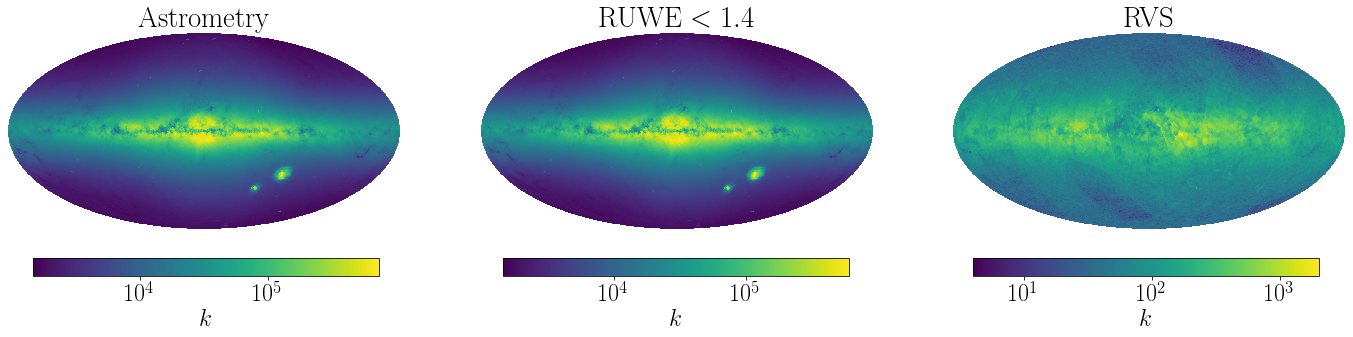

In [55]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))

labels = {'astrometry':'Astrometry', 'ruwe1p4':r'$\mathrm{RUWE}<1.4$','rvs':'RVS'}

minmax = [-4,4]

for i, sample in enumerate(['astrometry','ruwe1p4','rvs']):
    
#     M_bins = np.linspace(g_ranges[sample][0], g_ranges[sample][1]+eps, samples[sample]['M']+1)
#     C_bins = np.linspace(c_ranges[sample][0], c_ranges[sample][1]+eps, samples[sample]['C']+1)
    
#     M_subset = (M_bins[:-1] + mag_res/2>g_ranges[sample][0]) & (M_bins[:-1] + mag_res/2<g_ranges[sample][1])
#     C_subset = (C_bins[:-1] + col_res/2>c_ranges[sample][0]) & (C_bins[:-1] + col_res/2<c_ranges[sample][1])
    
    plt.sca(axes[i])
    arr = np.sum(box[sample]['k'], axis=(0,1)).copy().astype(float)
    arr[arr==0] = np.nan
    hp.mollview(arr, nest=True, notext=True,unit=r'$k$', norm='log',
                coord=['C','G'], title=labels[sample], cmap='viridis', hold=True, cbar=False, xsize=2000)
    
    cbar_ax = fig.add_axes([0.14+i*0.272, 0.1, 0.2, 0.05])
    ticks = 10**np.arange(10)
    add_log_cbar(cbar_ax, vmin=np.nanmin(arr), vmax=np.nanmax(arr), orientation='horizontal',
                ticks=ticks, tick_labels=[rf"$10^{{{j:.0f}}}$" for j in np.log10(ticks)])
    cbar_ax.set_xlabel(r'$k$')

# plt.savefig('figs/sample_k_3hpx.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

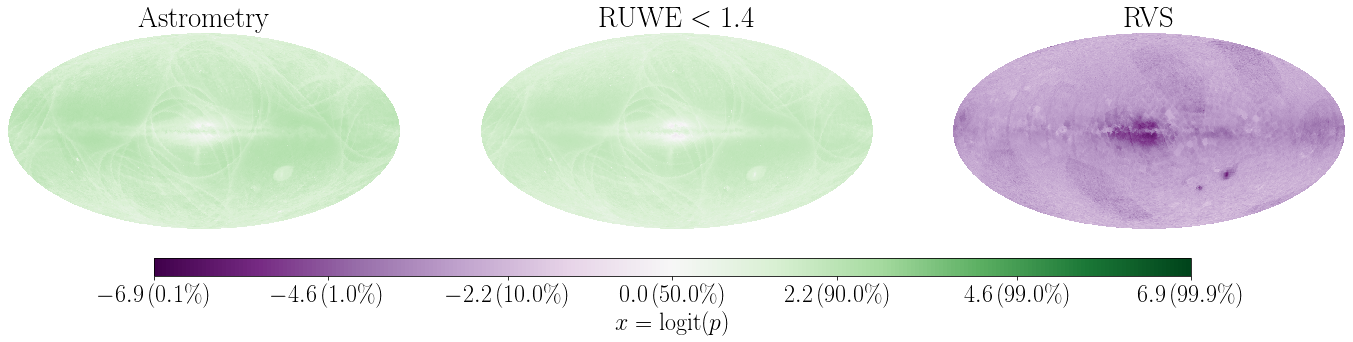

In [56]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))

labels = {'astrometry':'Astrometry', 'ruwe1p4':r'$\mathrm{RUWE}<1.4$','rvs':'RVS'}

minmax=[np.log(1/999),np.log(0.999/0.001)]

for i, sample in enumerate(['astrometry','ruwe1p4','rvs']):
    plt.sca(axes[i])
    
#     M_subset = (M_bins[:-1] + mag_res/2>g_ranges[sample][0]) & (M_bins[:-1] + mag_res/2<g_ranges[sample][1])
#     C_subset = (C_bins[:-1] + col_res/2>c_ranges[sample][0]) & (C_bins[:-1] + col_res/2<c_ranges[sample][1])
#     k = np.sum(box[sample]['k'][M_subset][:,C_subset], axis=(0,1)).copy().astype(float)
#     n = np.sum(box[sample]['n'][M_subset][:,C_subset], axis=(0,1)).copy().astype(float)
    k = np.sum(box[sample]['k'], axis=(0,1)).copy().astype(float)
    n = np.sum(box[sample]['n'], axis=(0,1)).copy().astype(float)
    
    hp.mollview(logit((k+1)/(n+2)), nest=True, notext=True, min=-7,max=7,
                coord=['C','G'], title=labels[sample], cmap='PRGn', hold=True, cbar=False, xsize=2000)
    
ax = fig.add_axes([0.21, 0.1, 0.6, 0.05]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
# cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0., minmax[1]])
# cbar.set_label(r'$\mathrm{logit}\left((k+1)/(n+2)\right)$', fontsize=24)

p=np.array([0.001,0.01,0.1,0.5,0.9,0.99,0.999]); ticks=np.log(p/(1-p))
tick_labels = [rf"${ticks[i]:.1f}\,({p[i]*100:.1f}\%)$" for i in range(len(p))]
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=ticks)
cbar.set_ticklabels(tick_labels)
cbar.set_label(r'$x = \mathrm{logit}(p)$', fontsize=24)

# plt.savefig('figs/sample_logitx_3hpx.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# Binomial tests

In [57]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/astrometry/PyOutput/'

In [58]:
from selectionfunctions.carpentry import chisel
from selectionfunctions.source import Source
import astropy.units as units
from selectionfunctions.std_paths import data_dir

In [95]:
samples = {'astrometry':{'M':85, 'C':1, 'lm':0.3, 'nside':64, 'jmax':5, 'lc':100., 'end':"_B2.0_ncores88"},
           'ruwe1p4':{'M':85, 'C':1, 'lm':0.3, 'nside':64, 'jmax':5, 'lc':200.0, 'end':"lc200.0_B2.0_ncores88"},
           'rvs':    {'M':61, 'C':4, 'lm':0.3, 'nside':64, 'jmax':5, 'lc':1.5, 'end':"lc1.5_B2.0_ncores80"}}

In [96]:
sf_box = {}
for sample in samples:
    sf_box[sample]={}
    nside=samples[sample]['nside']; jmax=samples[sample]['jmax']; B=2.; 
    run_name = f"chisquare_{sample}_jmax{jmax}_nside{nside}_M{samples[sample]['M']}_CGR{samples[sample]['C']}_lm{samples[sample]['lm']}{samples[sample]['end']}"
    map_fname = run_name + "_scipy_results.h5"

    with h5py.File(os.path.join(data_dir(),map_fname), 'r') as f:
        sf_box[sample]['x'] = f['x'][...]
        sf_box[sample]['b'] = f['b'][...]
        sf_box[sample]['z'] = f['z'][...]
        sf_box[sample]['Mbins'] = np.linspace(*f['Mlim'][...], samples[sample]['M']+1)
        sf_box[sample]['Cbins'] = np.linspace(*f['Clim'][...], samples[sample]['C']+1)

In [60]:
nside=32
for sample in ['rvs','ruwe1p4','astrometry']:
    box[sample]['n']=_downgrade(box[sample]['n'], samples[sample]['M'], samples[sample]['C'], samples[sample]['nside'])
    box[sample]['k']=_downgrade(box[sample]['k'], samples[sample]['M'], samples[sample]['C'], samples[sample]['nside'])

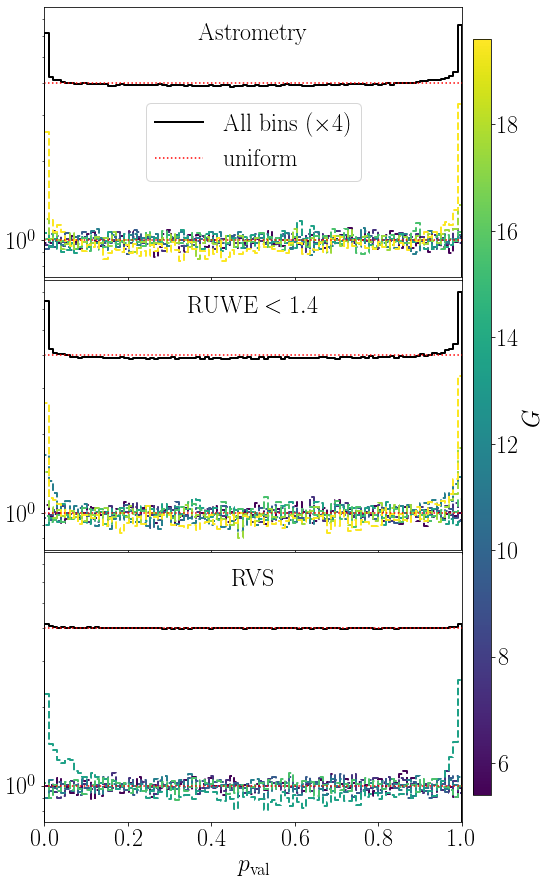

In [62]:
g = np.arange(5.5,21,2.)
c = 0.5

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(3,1,figsize=(8,15), sharex=True, sharey=True)

cmap = cm.viridis; mmin=np.min(g)-0.1; mmax=np.max(g)+0.1

for isamp, sample in enumerate(samples):
    plt.sca(axes[isamp])
    
    for i in range(len(g)):
        g_idx = np.sum(sf_box[sample]['Mbins']<g[i])-1
        c_idx = np.sum(sf_box[sample]['Cbins']<c)-1
        if g[i]>sf_box[sample]['Mbins'][-1]: 
            continue
        pval_k = scipy.stats.binom.cdf(box[sample]['k'][g_idx,c_idx], box[sample]['n'][g_idx,c_idx], expit(sf_box[sample]['x'][g_idx,c_idx]))
        pval_km1 = scipy.stats.binom.cdf(box[sample]['k'][g_idx,c_idx]-1, box[sample]['n'][g_idx,c_idx], expit(sf_box[sample]['x'][g_idx,c_idx]))
        pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
        plothist(pvals, bins=np.linspace(0,1,100), density=True,
                color=cmap((g[i]-mmin)/(mmax-mmin)), linewidth=2, linestyle='--')


    pval_k = scipy.stats.binom.cdf(box[sample]['k'], box[sample]['n'], expit(sf_box[sample]['x']))
    pval_km1 = scipy.stats.binom.cdf(box[sample]['k']-1, box[sample]['n'], expit(sf_box[sample]['x']))
    pvals = np.random.rand(*pval_k.shape)*(pval_k - pval_km1) + pval_km1
    plothist(pvals.flatten(), bins=np.linspace(0,1,100), label=r'All bins $(\times4)$', 
            color='k', linewidth=2, density=True, count=len(pvals.flatten())/4)

    plt.yscale('log')
    if isamp==2: plt.xlabel(r'$p_\mathrm{val}$', fontsize=24)


    plt.plot([0,1], [1,1], ':r', label='uniform')
    plt.plot([0,1], [4,4], ':r')
    #plt.plot(x, scipy.stats.logistic.pdf(x)*10, '--r')

vpos = axes[0].get_ylim()[0]**0.1 * axes[1].get_ylim()[1]**0.9
for isamp, sample in enumerate(samples):
    plt.sca(axes[isamp])
    plt.text(0.5,vpos,labels[sample],ha='center',va='center', fontsize=24)
    
plt.sca(axes[0]); plt.legend(loc='center')
plt.xlim(0,1)

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=24)

plt.subplots_adjust(hspace=0.01)

plt.savefig(f'figs/binompval_logithist_3sample_nside{nside}.png', bbox_inches='tight', dpi=100, facecolor='w', transparent=False)

# Source density

In [66]:
all_sf = {}
keys = ['astrometry', 'ruwe1p4', 'rvs']

for sample in samples:
    nside=samples[sample]['nside']; jmax=samples[sample]['jmax']; B=2.; 
    run_name = f"chisquare_{sample}_jmax{jmax}_nside{nside}_M{samples[sample]['M']}_CGR{samples[sample]['C']}_lm{samples[sample]['lm']}{samples[sample]['end']}"
    basis_options = {'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2}

    map_fname = run_name + "_scipy_results.h5"

    all_sf[sample] = chisel(map_fname=map_fname, nside=32, C=samples[sample]['C'], M=samples[sample]['M'], 
                            basis_options=basis_options,
                    lengthscale_m=samples[sample]['lm'], lengthscale_c=samples[sample]['lc'],
                    spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/')

Loading auxilliary data ...
Spherical Basis: wavelet_chisquare_nside32_B2.0_p1.0_tol0.01_j[-1,0,1,2,3,4,5].h5


/home/andy/py36/lib/python3.6/site-packages/selectionfunctions/SelectionFunctionUtils.py:99: RuntimeWarning: overflow encountered in power
  u = l*(l+1) / np.power(self.B,2.0*j)


Spherical basis file loaded
t = 1.923 s
  auxilliary:   0.042 s
          sf:   0.000 s
interpolator:   1.881 s
Loading auxilliary data ...
Spherical Basis: wavelet_chisquare_nside32_B2.0_p1.0_tol0.01_j[-1,0,1,2,3,4,5].h5
Spherical basis file loaded
t = 1.867 s
  auxilliary:   0.053 s
          sf:   0.000 s
interpolator:   1.814 s
Loading auxilliary data ...
Spherical Basis: wavelet_chisquare_nside32_B2.0_p1.0_tol0.01_j[-1,0,1,2,3,4,5].h5
Spherical basis file loaded
t = 2.165 s
  auxilliary:   0.186 s
          sf:   0.000 s
interpolator:   1.978 s


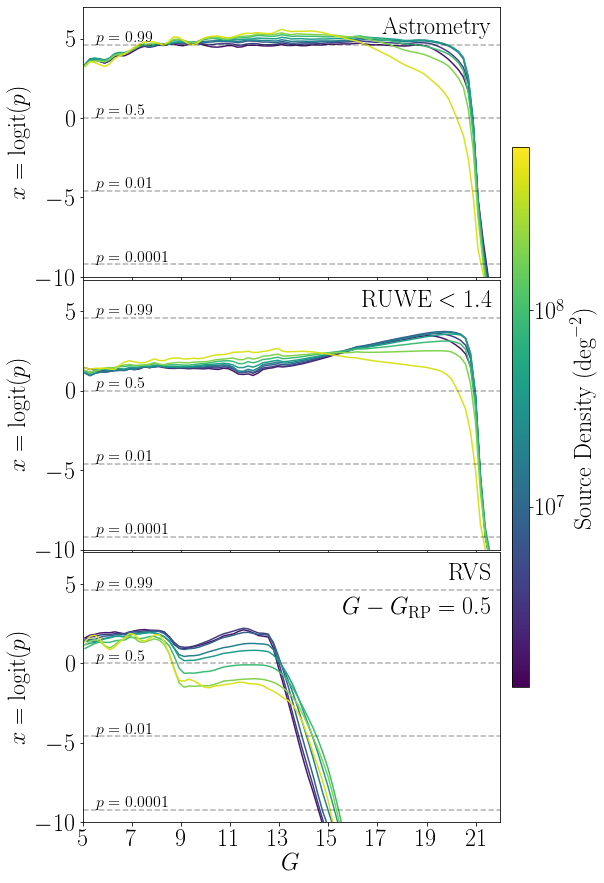

In [97]:
cmap=cm.viridis

labels = {'rvs':'RVS', 'ruwe1p4':r'$\mathrm{RUWE}<1.4$', 'astrometry':'Astrometry'}

fig, axes = plt.subplots(3,1,figsize=(8,15), sharex=True, sharey=True)
for isamp, sample in enumerate(samples):
    source_count = np.sum(box[sample]['n'], axis=(0,1))
    cidx = [0,0,1][isamp]
    area = hp.nside2pixarea(64)
    source_density = source_count/area
    sd_bins = np.logspace(np.log10(np.min(source_density)), np.log10(np.max(source_density)), 9)
    plt.sca(axes[isamp])
    for i, sd in enumerate(sd_bins[:-1]):

        pix = (source_density>sd_bins[i])&(source_density<sd_bins[i+1])

        sd = np.sqrt(sd_bins[i]*sd_bins[i+1])

        mean = np.sum(sf_box[sample]['x'][:,cidx,:].T[pix].T* source_count[pix], axis=1) /np.sum(source_count[pix])
        plt.plot(all_sf[sample].Mcenters, mean,
                c=cmap((np.log10(sd)-np.log10(sd_bins[0]))/(np.log10(sd_bins[-1])-np.log10(sd_bins[0]))))

    #     mean = np.sum(logit(prob_selection.T[pix]) * source_count[pix,None], axis=0) /np.sum(source_count[pix])
    #     plt.plot(g, mean / np.log(10),
    #             c=cmap((np.log10(sd)-np.log10(sd_bins[0]))/(np.log10(sd_bins[-1])-np.log10(sd_bins[0]))))

    if isamp==2: plt.xlabel(r'$G$'); 
    plt.ylabel(r'$x = \mathrm{logit}(p)$')
    plt.xlim(5, 22)
    axes[isamp].set_xticks(np.arange(5,21.1,2.))

    for p in [1e-4,1e-2,0.5,1-1e-2]:
        xlim = axes[isamp].get_xlim()
        plt.plot(xlim, [np.log(p/(1-p)), np.log(p/(1-p))], '--k', alpha=0.3)
        plt.text(5.5, np.log(p/(1-p))+0.2, rf'$p = {p}$', fontsize=16)
        #else: plt.text(5.5, np.log(p/(1-p))+0.2, r'$10^{%d}$' % np.log10(p), fontsize=12)
        
    plt.ylim(-10,7)
    xlim, ylim = axes[isamp].get_xlim(), axes[isamp].get_ylim()
    plt.text(xlim[0]*0.02+xlim[1]*0.98, 
             ylim[0]*0.04+ylim[1]*0.96,
             labels[sample], va='top', ha='right')
    if samples[sample]['C']>1:
        plt.text(xlim[0]*0.02+xlim[1]*0.98, 
                 ylim[0]*0.17+ylim[1]*0.83,
                 f"$G-G_\mathrm{{RP}}={(sf_box[sample]['Cbins'][cidx]+sf_box[sample]['Cbins'][cidx+1])/2}$", 
                 va='top', ha='right')
    
plt.subplots_adjust(hspace=0.01)
        
# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.25, 0.03, 0.5])
cbar = add_log_cbar(cbar_ax, cmap=cmap, vmin=sd_bins[0], vmax=sd_bins[-1],
                   ticks=10**(np.arange(5,10)), tick_labels=[r'$10^%d$' % i for i in np.arange(5,10)] )

cbar.set_label(r'Source Density $(\mathrm{deg}^{-2})$')


# plt.savefig(f'figs/x-vs-mag_meansd_m10_ruwemagonly.png', bbox_inches='tight', facecolor='w', transparent=False)

# RVS and RUWE CMD

In [76]:
samples = {'astrometry':{'M':85, 'C':1, 'lm':0.3, 'nside':64, 'jmax':5, 'lc':100., 'end':"_B2.0_ncores88"},
           'ruwe1p4':{'M':85, 'C':4, 'lm':0.3, 'nside':64, 'jmax':5, 'lc':3.0, 'end':"lc3.0_B2.0_ncores88"},
           'rvs':    {'M':61, 'C':4, 'lm':0.3, 'nside':64, 'jmax':5, 'lc':1.5, 'end':"lc1.5_B2.0_ncores80"}}

In [77]:
all_sf = {}

for sample in samples:
    nside=samples[sample]['nside']; jmax=samples[sample]['jmax']; B=2.; 
    run_name = f"chisquare_{sample}_jmax{jmax}_nside{nside}_M{samples[sample]['M']}_CGR{samples[sample]['C']}_lm{samples[sample]['lm']}{samples[sample]['end']}"
    basis_options = {'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2}

    map_fname = run_name + "_scipy_results.h5"

    all_sf[sample] = chisel(map_fname=map_fname, nside=32, C=samples[sample]['C'], M=samples[sample]['M'], 
                            basis_options=basis_options,
                    lengthscale_m=samples[sample]['lm'], lengthscale_c=samples[sample]['lc'],
                    spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/')

Loading auxilliary data ...
Spherical Basis: wavelet_chisquare_nside32_B2.0_p1.0_tol0.01_j[-1,0,1,2,3,4,5].h5


/home/andy/py36/lib/python3.6/site-packages/selectionfunctions/SelectionFunctionUtils.py:99: RuntimeWarning: overflow encountered in power
  u = l*(l+1) / np.power(self.B,2.0*j)


Spherical basis file loaded
t = 2.084 s
  auxilliary:   0.034 s
          sf:   0.000 s
interpolator:   2.050 s
Loading auxilliary data ...
Spherical Basis: wavelet_chisquare_nside32_B2.0_p1.0_tol0.01_j[-1,0,1,2,3,4,5].h5
Spherical basis file loaded
t = 2.367 s
  auxilliary:   0.412 s
          sf:   0.000 s
interpolator:   1.955 s
Loading auxilliary data ...
Spherical Basis: wavelet_chisquare_nside32_B2.0_p1.0_tol0.01_j[-1,0,1,2,3,4,5].h5
Spherical basis file loaded
t = 2.130 s
  auxilliary:   0.214 s
          sf:   0.000 s
interpolator:   1.916 s


In [74]:
l = [0.,0.]
b = [0.,90.]

col = {'rvs':np.linspace(-1.,3,81), 'ruwe1p4':np.linspace(-1.,7.,161)}
mag = {'rvs':np.linspace(5.,17.2,123), 'ruwe1p4':np.linspace(5.,22.,171)}
prob = {}
for isamp,sample in enumerate(['ruwe1p4','rvs']):
    cc, gg = np.meshgrid(col[sample], mag[sample])
    prob[sample] = np.zeros((2,*cc.shape))
    for ix in range(2):
        
        c = Source(l=np.zeros(cc.shape)+l[ix], b=np.zeros(cc.shape)+b[ix], unit='deg', frame='galactic',
                   photometry={'gaia_g':gg, 'gaia_bp_gaia_rp':cc})

        prob[sample][ix] = all_sf[sample](c)

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':


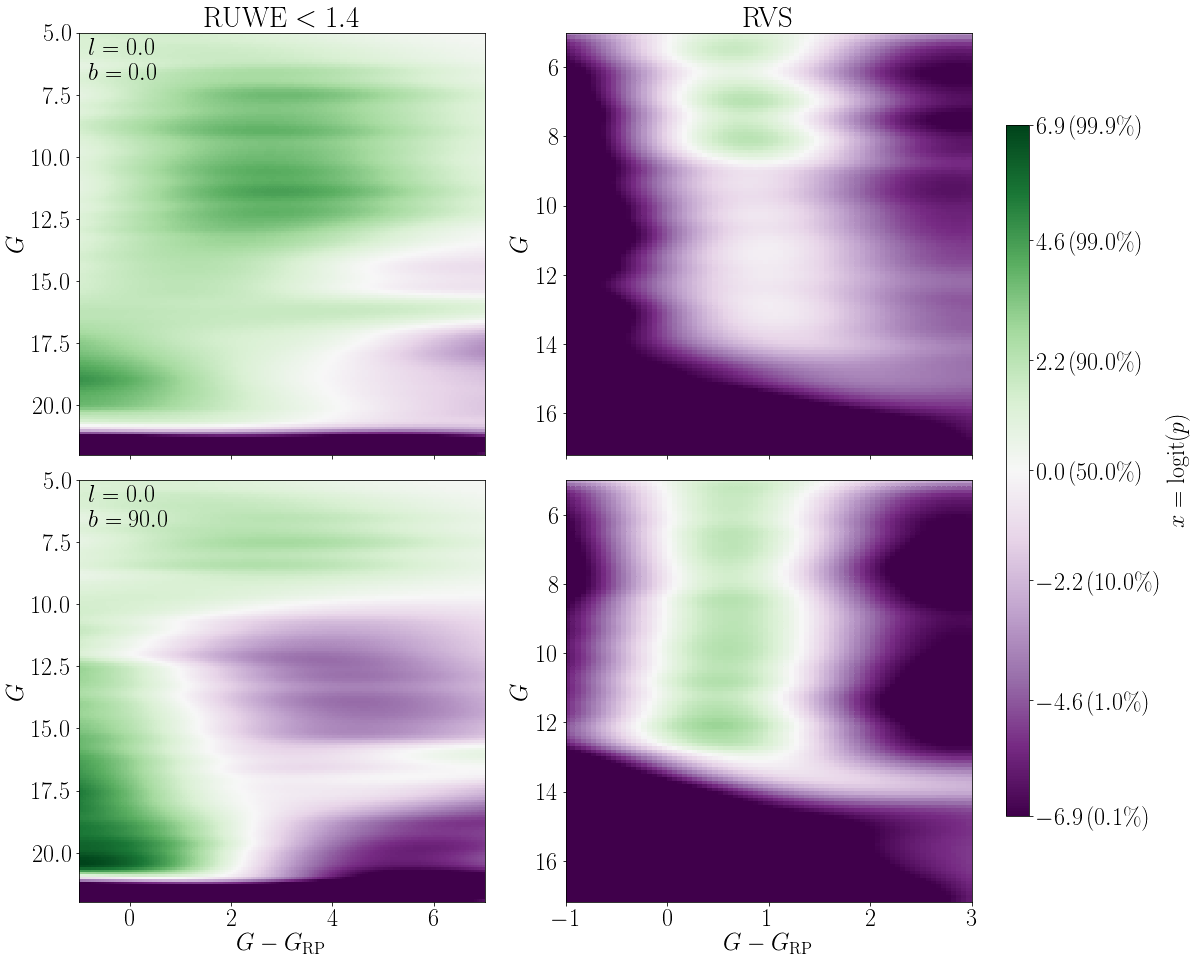

In [75]:
fig, axes = plt.subplots(2,2, figsize=(16,16), sharex='col', sharey='col')

minmax=[np.log(1/999),np.log(0.999/0.001)]
p=np.array([0.001,0.01,0.1,0.5,0.9,0.99,0.999]); ticks=np.log(p/(1-p))
tick_labels = [rf"${ticks[i]:.1f}\,({p[i]*100:.1f}\%)$" for i in range(len(p))]

labels = {'rvs':'RVS', 'ruwe1p4':r'$\mathrm{RUWE}<1.4$'}

for ix in range(2):
    for isamp, sample in enumerate(['ruwe1p4','rvs']):
        plt.sca(axes[ix,isamp])
        plt.pcolor(col[sample], mag[sample], logit(prob[sample][ix]), cmap='PRGn', vmin=minmax[0], vmax=minmax[1])
        
        if ix==0: plt.title(labels[sample])
        if ix==1: plt.xlabel(r'$G-G_\mathrm{RP}$')
        plt.ylabel(r'$G$')
        if isamp==0: 
            plt.text(-0.8, 5.2,rf'$l={l[ix]:.1f}$', ha='left', va='top')
            plt.text(-0.8, 6.2,rf'$b={b[ix]:.1f}$', ha='left', va='top')
            
        plt.ylim(mag[sample][-1], mag[sample][0])

ax = fig.add_axes([0.93, 0.2, 0.02, 0.6]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='vertical', ticks=ticks)
cbar.set_ticklabels(tick_labels)
cbar.set_label(r'$x = \mathrm{logit}(p)$', fontsize=24)

plt.subplots_adjust(hspace=0.06)

# plt.savefig(f'figs/x-cmd_b0b90.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

In [82]:
sf_box = {}
for sample in samples:
    sf_box[sample]={}
    nside=samples[sample]['nside']; jmax=samples[sample]['jmax']; B=2.; 
    run_name = f"chisquare_{sample}_jmax{jmax}_nside{nside}_M{samples[sample]['M']}_CGR{samples[sample]['C']}_lm{samples[sample]['lm']}{samples[sample]['end']}"
    map_fname = run_name + "_scipy_results.h5"

    with h5py.File(os.path.join(data_dir(),map_fname), 'r') as f:
        sf_box[sample]['x'] = f['x'][...]
        sf_box[sample]['b'] = f['b'][...]
        sf_box[sample]['z'] = f['z'][...]
        sf_box[sample]['Mbins'] = np.linspace(*f['Mlim'][...], samples[sample]['M']+1)
        sf_box[sample]['Cbins'] = np.linspace(*f['Clim'][...], samples[sample]['C']+1)

In [84]:
sf_box[sample]['Cbins']

array([-1.,  0.,  1.,  2.,  3.])

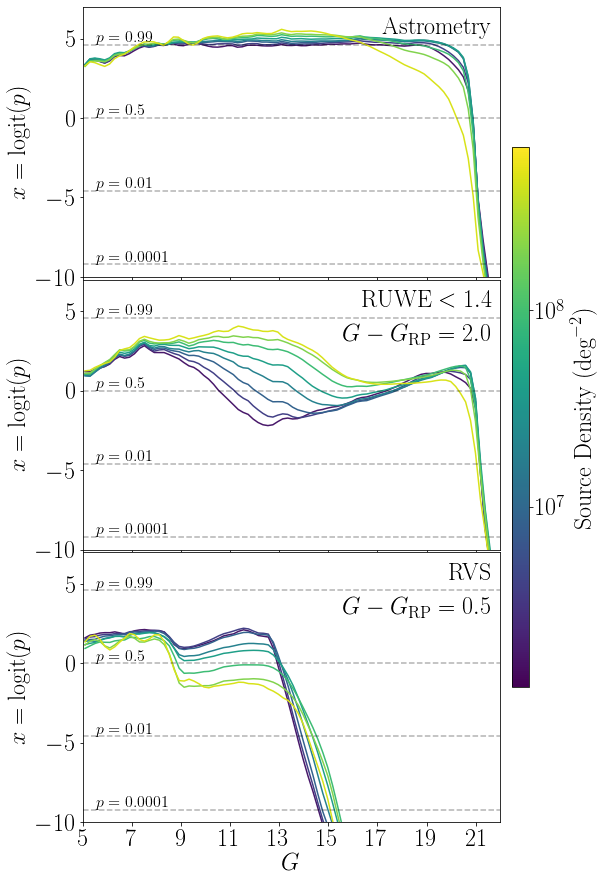

In [93]:
cmap=cm.viridis

labels = {'rvs':'RVS', 'ruwe1p4':r'$\mathrm{RUWE}<1.4$', 'astrometry':'Astrometry'}

fig, axes = plt.subplots(3,1,figsize=(8,15), sharex=True, sharey=True)
for isamp, sample in enumerate(samples):
    source_count = np.sum(box[sample]['n'], axis=(0,1))
    cidx = [0,1,1][isamp]
    area = hp.nside2pixarea(64)
    source_density = source_count/area
    sd_bins = np.logspace(np.log10(np.min(source_density)), np.log10(np.max(source_density)), 9)
    plt.sca(axes[isamp])
    for i, sd in enumerate(sd_bins[:-1]):

        pix = (source_density>sd_bins[i])&(source_density<sd_bins[i+1])

        sd = np.sqrt(sd_bins[i]*sd_bins[i+1])

        mean = np.sum(sf_box[sample]['x'][:,cidx,:].T[pix].T* source_count[pix], axis=1) /np.sum(source_count[pix])
        plt.plot(all_sf[sample].Mcenters, mean,
                c=cmap((np.log10(sd)-np.log10(sd_bins[0]))/(np.log10(sd_bins[-1])-np.log10(sd_bins[0]))))

    #     mean = np.sum(logit(prob_selection.T[pix]) * source_count[pix,None], axis=0) /np.sum(source_count[pix])
    #     plt.plot(g, mean / np.log(10),
    #             c=cmap((np.log10(sd)-np.log10(sd_bins[0]))/(np.log10(sd_bins[-1])-np.log10(sd_bins[0]))))

    if isamp==2: plt.xlabel(r'$G$'); 
    plt.ylabel(r'$x = \mathrm{logit}(p)$')
    plt.xlim(5, 22)
    axes[isamp].set_xticks(np.arange(5,21.1,2.))

    for p in [1e-4,1e-2,0.5,1-1e-2]:
        xlim = axes[isamp].get_xlim()
        plt.plot(xlim, [np.log(p/(1-p)), np.log(p/(1-p))], '--k', alpha=0.3)
        plt.text(5.5, np.log(p/(1-p))+0.2, rf'$p = {p}$', fontsize=16)
        #else: plt.text(5.5, np.log(p/(1-p))+0.2, r'$10^{%d}$' % np.log10(p), fontsize=12)
        
    plt.ylim(-10,7)
    xlim, ylim = axes[isamp].get_xlim(), axes[isamp].get_ylim()
    plt.text(xlim[0]*0.02+xlim[1]*0.98, 
             ylim[0]*0.04+ylim[1]*0.96,
             labels[sample], va='top', ha='right')
    if samples[sample]['C']>1:
        plt.text(xlim[0]*0.02+xlim[1]*0.98, 
                 ylim[0]*0.17+ylim[1]*0.83,
                 f"$G-G_\mathrm{{RP}}={(sf_box[sample]['Cbins'][cidx]+sf_box[sample]['Cbins'][cidx+1])/2}$", 
                 va='top', ha='right')
    
    
plt.subplots_adjust(hspace=0.01)
        
# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.25, 0.03, 0.5])
cbar = add_log_cbar(cbar_ax, cmap=cmap, vmin=sd_bins[0], vmax=sd_bins[-1],
                   ticks=10**(np.arange(5,10)), tick_labels=[r'$10^%d$' % i for i in np.arange(5,10)] )

cbar.set_label(r'Source Density $(\mathrm{deg}^{-2})$')


plt.savefig(f'figs/x-vs-mag_meansd.png', bbox_inches='tight', facecolor='w', transparent=False)

In [64]:
np.sum(box['astrometry']['k'])/np.sum(box['astrometry']['n']), \
np.sum(box['ruwe1p4']['k'])/np.sum(box['ruwe1p4']['n'])

(0.8112297733218952, 0.7755701873984846)

# Needlet weights vs mag - these plots aren't very good.

In [25]:
prob.shape

(500, 2)

NameError: name 'ruwe_sf' is not defined

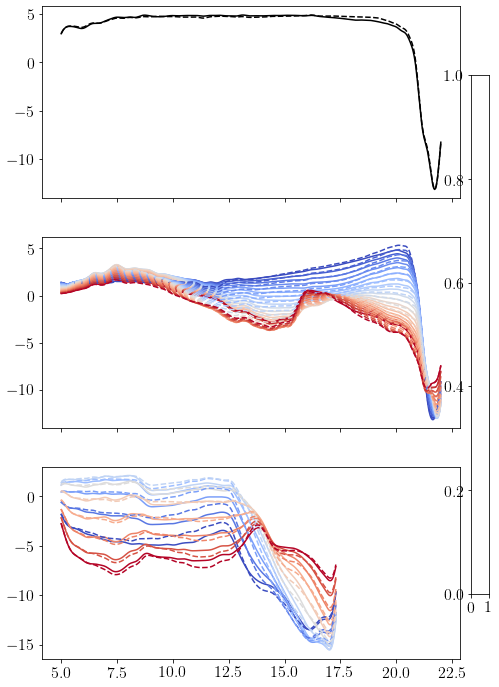

In [31]:
fig, axes = plt.subplots(len(samples),1,figsize=(8,12), sharex=True)

cmap = cm.coolwarm

imode=0
linestyles = ['-','--']

for i, sample in enumerate(samples):
    
    plt.sca(axes[i])
    
    if i==0: 
        g = np.linspace(all_sf[sample].Mbins[0],all_sf[sample].Mbins[-1],500)
        col = np.arange(all_sf[sample].Ccenters[0], all_sf[sample].Ccenters[-1]+0.01, 1.)
        l = np.array([0., 0.])
        b = np.array([0., 90.])
        ll, gg = np.meshgrid(l, g)
        bb, gg = np.meshgrid(b, g)
        c = Source(l=ll, b=bb, unit='deg', frame='galactic', photometry={'gaia_g':gg})

        prob = all_sf[sample](c)

        for j in range(prob.shape[1]):
            if i==0: plt.plot(g, logit(prob[:,j]), linestyle=linestyles[j], color='k')
                
    else: 
        l = np.array([0., 0.])
        b = np.array([0., 90.])
        g = np.linspace(all_sf[sample].Mbins[0],all_sf[sample].Mbins[-1],500)
        col = np.arange(all_sf[sample].Ccenters[0], all_sf[sample].Ccenters[-1]+0.01, .5)
        cc, gg = np.meshgrid(col, g)
        cc, gg = np.meshgrid(col, g)
        for ix in range(len(l)):
            c = Source(l=np.zeros(cc.shape)+l[ix], b=np.zeros(cc.shape)+b[ix], unit='deg', frame='galactic', photometry={'gaia_g':gg, 'gaia_bp_gaia_rp':cc})
            prob = all_sf[sample](c)
            for iC in range(len(col)):
                plt.plot(g, logit(prob[:,iC]), linestyle=linestyles[ix], color=cmap((col[iC]-col[0])/(col[-1]-col[0])))
            
# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.03, 0.6])
norm = matplotlib.colors.Normalize(vmin=col[0],vmax=col[-1])
im = plt.cm.ScalarMappable(norm=norm, cmap=cmap); im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=ruwe_sf.Ccenters)
cbar.set_label(r'$G - G_\mathrm{RP}$', fontsize=24)
    
plt.sca(axes[2])
plt.xlabel(r'$G$'); 
plt.xlim(np.min(g), np.max(g))

plt.subplots_adjust(hspace=0.01)

# plt.savefig('figs/ruwe/%s_GP_col-mag_3l_m.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)

In [142]:
g = np.linspace(M_bins[0],M_bins[-1],500)
col = np.arange(ruwe_sf.Ccenters[0], ruwe_sf.Ccenters[-1]+0.01, 1.)
cc, gg = np.meshgrid(col, g)

# Contstruct covariance kernel for new positions.
KmM = ruwe_sf.covariance_kernel(gg.flatten(), ruwe_sf.Mcenters, lengthscale=ruwe_sf.lengthscale_m)
KcC = ruwe_sf.covariance_kernel(cc.flatten(), ruwe_sf.Ccenters, lengthscale=ruwe_sf.lengthscale_c)

# Estimate alm using Gaussian Process
_b = np.sum ( ((KmM @ ruwe_sf._inv_KMM) @ ruwe_sf.b) * (KcC @ ruwe_sf._inv_KCC)[None, :,:] , axis=2)
_b = _b.reshape(-1, *gg.shape)

In [143]:
def closest_pix(nside, _l, _b):
    ra, dec = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), lonlat=True, nest=False)
    coord = SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs').galactic
    l,b = coord.l.rad, coord.b.rad
    gamma = np.arccos(np.sin(l[None,:])*np.sin(_l[:,None]) + np.cos(l[None,:])*np.cos(_l[:,None])*np.cos(b[None,:]-_b[:,None]))
    return gamma, np.rad2deg(l), np.rad2deg(b)

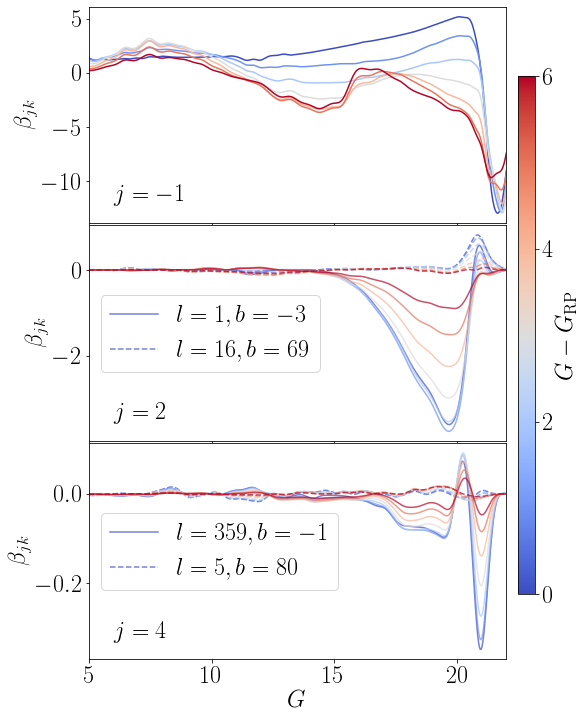

In [144]:
fig, axes = plt.subplots(3,1,figsize=(8,12), sharex=True)

cmap = cm.coolwarm

j_vals = [-1,2,4]
imode=0
pix_linestyles = ['-','--']

for iC in range(_b.shape[2]):
    rgb_color = cmap((col[iC]-col[0])/(col[-1]-col[0]))
    for i, _j in enumerate(j_vals):
        plt.sca(axes[i])
        if _j==-1:
            plt.plot(g, _b[0,:,iC], linestyle='-', color=rgb_color)
        else:
            if _j>0: imode = np.sum([hp.nside2npix(nside) for nside in 2**np.arange(_j-1)])
            else: imode=1
            gamma, l, b = closest_pix(2**_j, np.array([0.,0.]), np.array([0.,np.pi/2]))
            pix = np.argmin(gamma, axis=1)
            
            for ipix in range(2):
                if iC==0:kwargs={'alpha':0.7, 'color':rgb_color, 'label':rf"$l={l[pix[ipix]]:.0f},b={b[pix[ipix]]:.0f}$"}
                else:kwargs={'alpha':0.7, 'color':rgb_color}
                plt.plot(g, _b[imode+pix[ipix],:,iC], linestyle=pix_linestyles[ipix], **kwargs)
                
        if (iC==0)&(_j>-1): plt.legend(loc='center left')

        if iC==_b.shape[2]-1:
            ylim = axes[i].get_ylim()
            plt.text(6., (ylim[1]-ylim[0])*0.1 + ylim[0], r"$j=%d$" % _j)
            plt.ylabel(r'$\beta_{jk}$')
            
# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.03, 0.6])
norm = matplotlib.colors.Normalize(vmin=col[0],vmax=col[-1])
im = plt.cm.ScalarMappable(norm=norm, cmap=cmap); im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=ruwe_sf.Ccenters)
cbar.set_label(r'$G - G_\mathrm{RP}$', fontsize=24)
    
plt.sca(axes[2])
plt.xlabel(r'$G$'); 
plt.xlim(np.min(g), np.max(g))

plt.subplots_adjust(hspace=0.01)

plt.savefig('figs/ruwe/%s_GP_col-mag_3l_m.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)